# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head() 

dfdata

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048
...,...,...,...,...,...,...,...,...,...,...,...
38044,176,-75,12,-319.0,24.685835,7.810156,1.786629,364.379761,34.312950,66.335876,-1.173618
38045,177,-75,12,-358.0,24.840891,7.860805,1.802742,364.401703,34.288509,65.940857,-1.132929
38046,178,-75,7,-396.0,24.974289,7.906945,1.817465,340.104584,34.263248,65.475494,-1.014320
38047,179,-75,7,-429.0,25.085926,7.938530,1.831387,320.717895,34.239590,64.965263,-0.846849


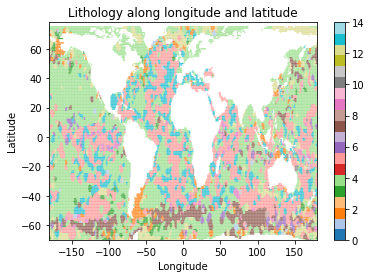

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.1, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

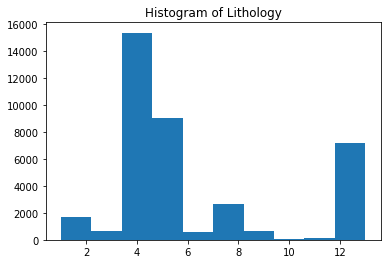

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [4]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [5]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

Using TensorFlow backend.


In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(numclass, activation="softmax", kernel_initializer=initializer))
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

In [7]:
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)

train_indice, test_indice = [], []
for train, test in kfold.split(X):
    train_indice.append(train)
    test_indice.append(test)
    
result = np.zeros((len(Y), len(np.unique(Y))))

for train_ind, test_ind in kfold.split(X):
    Xtrain = X[train_ind]
    Ytrain = dummy_Y[train_ind]
    Xtest = X[test_ind]
    # train
    estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True)
    estimator.fit(X[train_ind], dummy_Y[train_ind], class_weight=weight)
    # predict
    prediction = estimator.predict_proba(X[test_ind])
    result[test_ind, :] = prediction

Epoch 1/200
25366/25366 [==============================] - 4s 166us/step - loss: 1.5067 - accuracy: 0.4775
Epoch 2/200
25366/25366 [==============================] - 4s 162us/step - loss: 1.4069 - accuracy: 0.5162
Epoch 3/200
25366/25366 [==============================] - 4s 162us/step - loss: 1.3724 - accuracy: 0.5315
Epoch 4/200
25366/25366 [==============================] - 4s 158us/step - loss: 1.3499 - accuracy: 0.5392
Epoch 5/200
25366/25366 [==============================] - 4s 162us/step - loss: 1.3370 - accuracy: 0.5445
Epoch 6/200
25366/25366 [==============================] - 4s 154us/step - loss: 1.3236 - accuracy: 0.5444
Epoch 7/200
25366/25366 [==============================] - 4s 160us/step - loss: 1.3089 - accuracy: 0.5482
Epoch 8/200
25366/25366 [==============================] - 4s 158us/step - loss: 1.2956 - accuracy: 0.5491
Epoch 9/200
25366/25366 [==============================] - 4s 159us/step - loss: 1.2851 - accuracy: 0.5538
Epoch 10/200
25366/25366 [===========

In [8]:
result_discrete = result.argmax(axis=1)
result_discrete

array([ 3,  3,  3, ..., 11, 11, 11])

In [9]:
result

array([[1.82495061e-11, 6.77049968e-07, 3.23610206e-04, ...,
        8.42456225e-29, 4.94117022e-01, 1.86573104e-08],
       [1.60834579e-18, 8.47649229e-10, 5.29839975e-20, ...,
        4.53118579e-19, 3.13804066e-10, 8.23420065e-12],
       [5.66537036e-20, 3.57775976e-10, 1.31637838e-20, ...,
        2.30359251e-20, 1.29769806e-10, 6.02247690e-13],
       ...,
       [1.62861366e-02, 7.73694657e-04, 1.19368976e-03, ...,
        4.35834702e-10, 8.05023313e-01, 3.39858147e-04],
       [8.23874865e-03, 6.11664988e-02, 9.14562587e-03, ...,
        1.33476127e-03, 3.79041523e-01, 4.99539031e-03],
       [5.40636033e-02, 2.32735097e-01, 2.66630366e-03, ...,
        1.74825210e-02, 3.23906034e-01, 1.48348016e-04]])

Accuracy = 0.6306604641383479


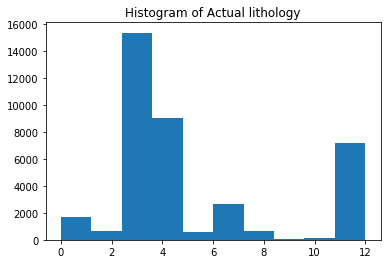

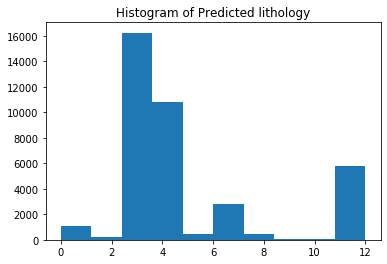

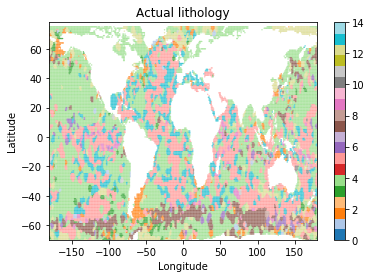

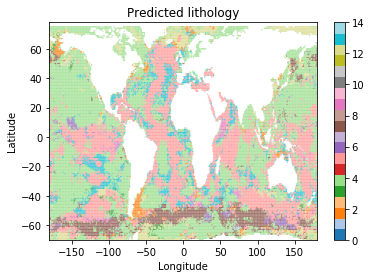

In [10]:
print("Accuracy = {}".format(accuracy_score(Y, result_discrete)))
draw_hist(Y, "Histogram of Actual lithology")
draw_hist(result_discrete, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, result_discrete + 1, "Predicted lithology")

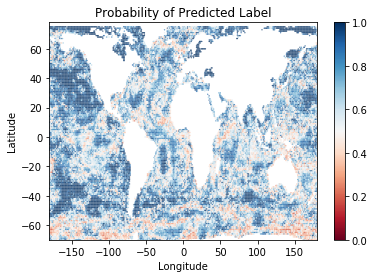

In [11]:
prob = np.max(result, axis=1)
draw_global(lon, lat, prob, "Probability of Predicted Label", cmap='RdBu', vmin=0, vmax=1)

In [23]:
to_save = pd.DataFrame({"lon": lon, "lat": lat, "result_discrete": result_discrete, "prob": prob})
to_save.to_csv("result.csv", index=False)
to_save


,lon,lat,result_discrete,prob
0,-180,75,3,0.505558
1,-179,75,3,0.999999
2,-178,75,3,1.000000
3,-177,75,3,1.000000
4,-176,75,3,0.887997
...,...,...,...,...
38044,176,-75,11,0.393108
38045,177,-75,11,0.382211
38046,178,-75,11,0.805023
38047,179,-75,11,0.379042


In [17]:
!pip install cartopy

  Using cached https://files.pythonhosted.org/packages/46/c1/04e50c9986842f00f7db0e7a65caa896840050d7328f74e5b7437aa01179/Cartopy-0.18.0.tar.gz
    ERROR: Command errored out with exit status 1:
     command: /Users/wan220/.virtualenvs/sea/bin/python3.7 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/0y/5h4t5tb902j7rh2rb2smc44h00lgw5/T/pip-install-9cij9hnf/cartopy/setup.py'"'"'; __file__='"'"'/private/var/folders/0y/5h4t5tb902j7rh2rb2smc44h00lgw5/T/pip-install-9cij9hnf/cartopy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/0y/5h4t5tb902j7rh2rb2smc44h00lgw5/T/pip-install-9cij9hnf/cartopy/pip-egg-info
         cwd: /private/var/folders/0y/5h4t5tb902j7rh2rb2smc44h00lgw5/T/pip-install-9cij9hnf/cartopy/
    Complete output (5 lines):
    /private/var/folders/0y/5h4t5tb902j7rh2rb2smc44h00lgw5/T/p

In [16]:
!pip install cpython

     |████████████████████████████████| 378kB 2.2MB/s eta 0:00:01
Failed to build cpython
    Running setup.py install for cpython ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
